In [1]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
#define common variables
channels = 3 #RGB
img_w = 64
img_h = 64
input_shape = (img_h, img_w, channels)
path = "../satellite_images/images"

In [3]:
#create tf datasets from the images: tf.Data.dataset
# labels NoTrees = 0, Trees = 1

training = tf.keras.utils.image_dataset_from_directory(directory=path,
    labels='inferred',
    label_mode='binary',
    class_names=None,
    color_mode='rgb',
    batch_size=16,
    image_size=(img_h, img_w),
    shuffle=True,
    seed=47,
    validation_split=0.25,
    subset='training')

test = tf.keras.utils.image_dataset_from_directory(directory=path,
    labels='inferred',
    label_mode='binary',
    class_names=None,
    color_mode='rgb',
    batch_size=16,
    image_size=(img_h, img_w),
    shuffle=False,
    seed=47,
    validation_split=0.25,
    subset='validation')

Found 10332 files belonging to 2 classes.
Using 7749 files for training.
Found 10332 files belonging to 2 classes.
Using 2583 files for validation.


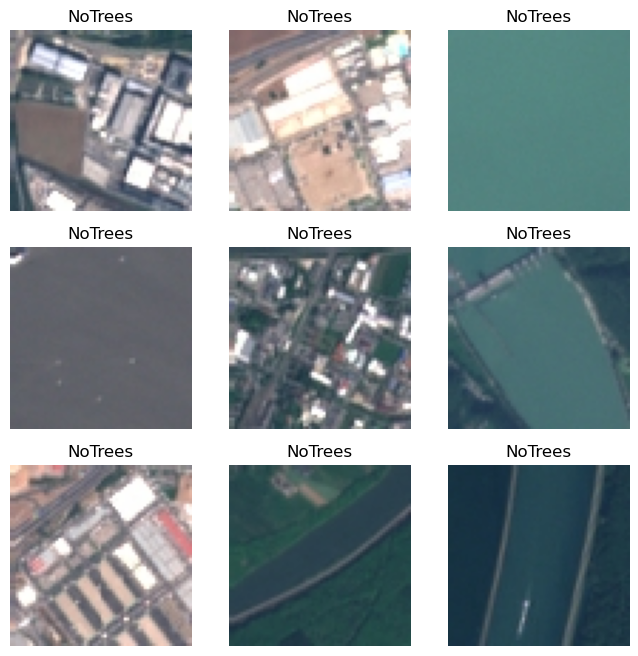

In [4]:
#show first 9 images and labels from the training set:
class_names = training.class_names

plt.figure(figsize=(8, 8))
for images, labels in training.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i], axis=None, out=None)])
        plt.axis("off")

In [62]:
# build a network from scratch
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, Dense, Conv2D, Flatten, MaxPool2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

model_1 = Sequential(name="model_1")
model_1.add(Rescaling((1./255), input_shape=(img_h, img_w, 3)))
model_1.add(Conv2D(16, kernel_size=3, padding='same', activation = 'relu'))
model_1.add(MaxPool2D())
model_1.add(BatchNormalization())
model_1.add(Conv2D(32, kernel_size=3, padding='same', activation= 'relu'))
model_1.add(MaxPool2D())
model_1.add(BatchNormalization())
model_1.add(Flatten())
model_1.add(Dense(64, activation='relu'))
model_1.add(Dense(1, activation='sigmoid')) #1 for binary output


In [63]:
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [64]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_10 (Rescaling)    (None, 64, 64, 3)         0         
                                                                 
 conv2d_19 (Conv2D)          (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                            
                                                                 
 batch_normalization_17 (Bat  (None, 32, 32, 16)       64        
 chNormalization)                                                
                                                                 
 conv2d_20 (Conv2D)          (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 16, 16, 32)       0   

In [65]:
from time import time

In [66]:
start = time()

early_stopping_monitor = EarlyStopping(patience=3)

history_model_1 = model_1.fit(training, validation_data=test, epochs=20, callbacks=[early_stopping_monitor])

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/20
485/485 [==============================] - 32s 64ms/step - loss: 0.3720 - accuracy: 0.8609 - val_loss: 0.3494 - val_accuracy: 0.8637
Epoch 2/20
485/485 [==============================] - 31s 63ms/step - loss: 0.2173 - accuracy: 0.9132 - val_loss: 0.0581 - val_accuracy: 0.9826
Epoch 3/20
485/485 [==============================] - 31s 64ms/step - loss: 0.1685 - accuracy: 0.9364 - val_loss: 0.1161 - val_accuracy: 0.9636
Epoch 4/20
485/485 [==============================] - 31s 63ms/step - loss: 0.1545 - accuracy: 0.9391 - val_loss: 0.9506 - val_accuracy: 0.7027
Epoch 5/20
485/485 [==============================] - 32s 65ms/step - loss: 0.1147 - accuracy: 0.9586 - val_loss: 1.0522 - val_accuracy: 0.5207
Elapsed Time = 166.62790083885193 seconds


Now that I have a proper model run, I'll make a function to plot the learning curves:

In [10]:
def plot_learning_curve(history):
    tr_loss = history.history['loss']
    val_loss = history.history['val_loss']
    tr_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    # Plot the training and validation loss
    plt.figure(figsize=(12,8))
    plt.subplot(1,2,1)
    plt.plot(tr_loss, label="Training Loss", color='blue')
    plt.plot(val_loss, label="Validation Loss", color='orange')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")
    
    # Plot the train and val accuracy
    plt.subplot(1,2,2)
    plt.plot(tr_acc, label="Training Accuracy", color='blue')
    plt.plot(val_acc, label="Validation Accuracy", color='orange')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training and Validation Accuracy")         

    # Show the figure
    plt.show()

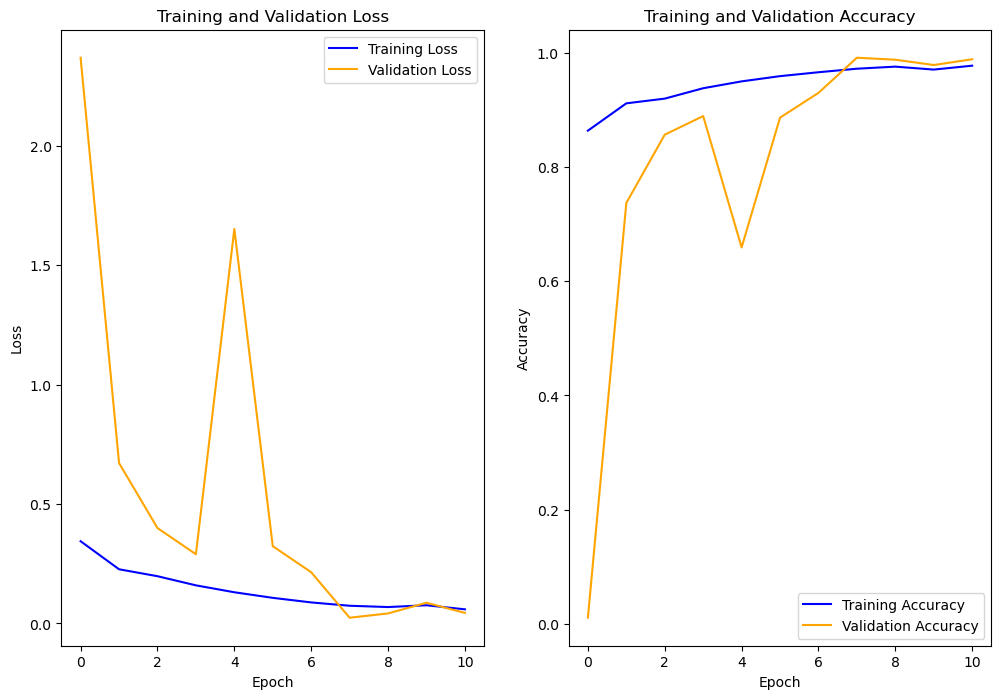

In [11]:
model_1_plots = plot_learning_curve(history)

So, it looks like improvements in the training accuracy and loss start to level off after around 10-12 epochs. The validation loss and accuracy bounce around but then appear to get worse after the 13th epoch. I will try out a slower learning rate to see if that reduces the noise in the validation learning curves and introduce early stopping:

In [82]:
#model 2
model_2 = Sequential(name="model_2")
model_2.add(Rescaling((1./255), input_shape=(img_h, img_w, 3)))
model_2.add(Conv2D(16, kernel_size=3, padding='same', activation = 'relu'))
model_2.add(MaxPool2D())
model_2.add(BatchNormalization())
model_2.add(Conv2D(32, kernel_size=3, padding='same', activation= 'relu'))
model_2.add(MaxPool2D())
model_2.add(BatchNormalization())
model_2.add(Flatten())
model_2.add(Dense(64, activation='relu'))
model_2.add(Dense(1, activation='sigmoid'))

In [13]:
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007), loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
class LearningRateReducerCb(tf.keras.callbacks.Callback):

  def on_epoch_end(self, epoch, logs={}):
    old_lr = self.model.optimizer.lr.read_value()
    new_lr = old_lr * 0.99
    print("\nEpoch: {}. Reducing Learning Rate from {} to {}".format(epoch, old_lr, new_lr))
    self.model.optimizer.lr.assign(new_lr)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=3)
#lr_reducer = tf.keras.callbacks.LearningRateScheduler(scheduler)

start = time()

# Fit the model
history_model_2 = model_2.fit(training, validation_data=test, epochs=20, callbacks=[early_stopping_monitor])

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/20
485/485 [==============================] - 40s 81ms/step - loss: 0.3337 - accuracy: 0.8620 - val_loss: 3.2478 - val_accuracy: 0.0105
Epoch 2/20
485/485 [==============================] - 40s 81ms/step - loss: 0.1938 - accuracy: 0.9224 - val_loss: 0.3120 - val_accuracy: 0.9106
Epoch 3/20
485/485 [==============================] - 36s 75ms/step - loss: 0.1427 - accuracy: 0.9453 - val_loss: 0.1754 - val_accuracy: 0.9458
Epoch 4/20
485/485 [==============================] - 36s 73ms/step - loss: 0.1155 - accuracy: 0.9563 - val_loss: 0.1477 - val_accuracy: 0.9481
Epoch 5/20
485/485 [==============================] - 36s 74ms/step - loss: 0.0931 - accuracy: 0.9622 - val_loss: 0.2473 - val_accuracy: 0.9082
Epoch 6/20
485/485 [==============================] - 39s 80ms/step - loss: 0.0907 - accuracy: 0.9653 - val_loss: 0.0262 - val_accuracy: 0.9915
Epoch 7/20
485/485 [==============================] - 34s 71ms/step - loss: 0.0733 - accuracy: 0.9730 - val_loss: 0.1600 - val_accuracy:

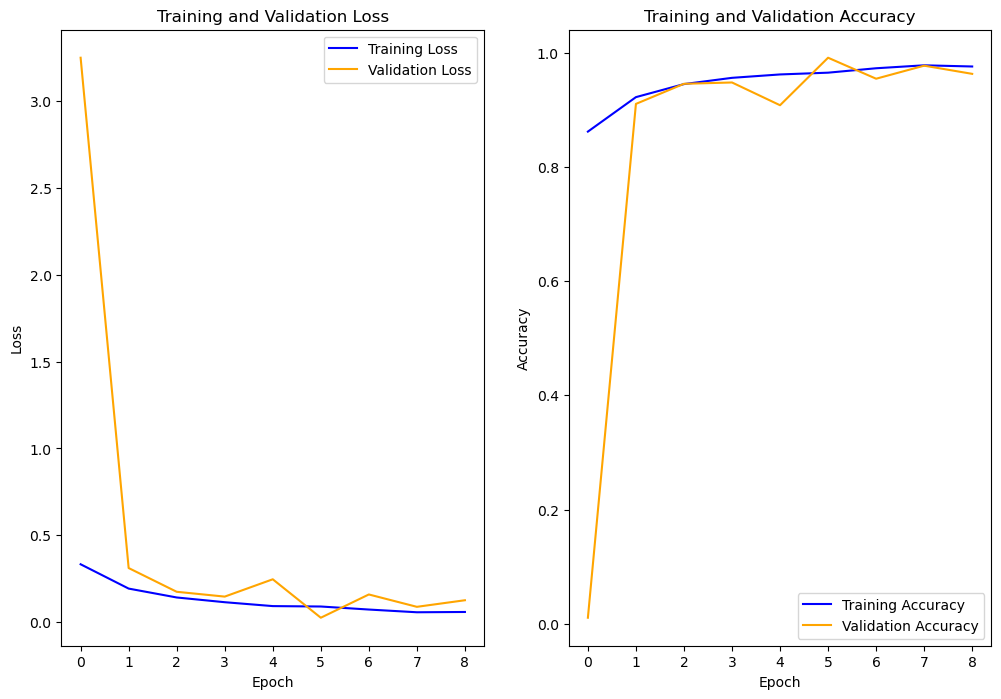

In [16]:
model_2_plots = plot_learning_curve(history_model_2)

Reducing the learning rate got rid of a lot of the jumpiness in the validation learning curves. And with the early stopping callback parameter validation accuracy hit a peak on the 3rd epoch and did not improve past that mark after three more epochs and so training stopped. 
The next network below will add more neurons to the convolutional and dense layers

In [71]:
#let's try the same model architecture as model_2 but with a slightly slower learning rate
model_2a = Sequential(name="model_2a")
model_2a.add(Rescaling((1./255), input_shape=(img_h, img_w, 3)))
model_2a.add(Conv2D(16, kernel_size=3, padding='same', activation = 'relu'))
model_2a.add(MaxPool2D())
model_2a.add(BatchNormalization())
model_2a.add(Conv2D(32, kernel_size=3, padding='same', activation= 'relu'))
model_2a.add(MaxPool2D())
model_2a.add(BatchNormalization())
model_2a.add(Flatten())
model_2a.add(Dense(64, activation='relu'))
model_2a.add(Dense(1, activation='sigmoid'))

model_2a.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0006), loss='binary_crossentropy', metrics=['accuracy'])

start = time()

# Fit the model
history_model_2a = model_2a.fit(training, validation_data=test, epochs=20, callbacks=[early_stopping_monitor])

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/20
485/485 [==============================] - 36s 72ms/step - loss: 0.3096 - accuracy: 0.8797 - val_loss: 3.0526 - val_accuracy: 0.0372
Epoch 2/20
485/485 [==============================] - 33s 67ms/step - loss: 0.1806 - accuracy: 0.9297 - val_loss: 0.0866 - val_accuracy: 0.9686
Epoch 3/20
485/485 [==============================] - 31s 64ms/step - loss: 0.1337 - accuracy: 0.9488 - val_loss: 0.1786 - val_accuracy: 0.9326
Epoch 4/20
485/485 [==============================] - 33s 67ms/step - loss: 0.1287 - accuracy: 0.9477 - val_loss: 0.1049 - val_accuracy: 0.9675
Epoch 5/20
485/485 [==============================] - 34s 69ms/step - loss: 0.0891 - accuracy: 0.9658 - val_loss: 0.1496 - val_accuracy: 0.9593
Elapsed Time = 166.9025046825409 seconds


In [84]:
#model 3
model_3 = Sequential(name="model_3")
model_3.add(Rescaling((1./255), input_shape=(img_h, img_w, 3)))
model_3.add(Conv2D(24, kernel_size=3, padding='same', activation = 'relu'))
model_3.add(MaxPool2D())
model_3.add(BatchNormalization())
model_3.add(Conv2D(48, kernel_size=3, padding='same', activation= 'relu'))
model_3.add(MaxPool2D())
model_3.add(BatchNormalization())
model_3.add(Flatten())
model_3.add(Dense(96, activation='relu'))
model_3.add(Dense(1, activation='sigmoid'))

model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007), loss='binary_crossentropy', metrics=['accuracy'])
model_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_13 (Rescaling)    (None, 64, 64, 3)         0         
                                                                 
 conv2d_25 (Conv2D)          (None, 64, 64, 24)        672       
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 32, 32, 24)       0         
 g2D)                                                            
                                                                 
 batch_normalization_23 (Bat  (None, 32, 32, 24)       96        
 chNormalization)                                                
                                                                 
 conv2d_26 (Conv2D)          (None, 32, 32, 48)        10416     
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 16, 16, 48)       0   

In [19]:
start = time()

# Fit the model
history_model_3 = model_3.fit(training, validation_data=test, epochs=20, callbacks=[early_stopping_monitor])

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/20
485/485 [==============================] - 44s 89ms/step - loss: 0.3730 - accuracy: 0.8690 - val_loss: 2.4907 - val_accuracy: 0.0105
Epoch 2/20
485/485 [==============================] - 44s 91ms/step - loss: 0.2130 - accuracy: 0.9135 - val_loss: 0.3508 - val_accuracy: 0.8854
Epoch 3/20
485/485 [==============================] - 48s 98ms/step - loss: 0.1616 - accuracy: 0.9355 - val_loss: 0.8026 - val_accuracy: 0.7712
Epoch 4/20
485/485 [==============================] - 49s 100ms/step - loss: 0.1501 - accuracy: 0.9435 - val_loss: 0.8357 - val_accuracy: 0.7828
Epoch 5/20
485/485 [==============================] - 51s 106ms/step - loss: 0.1426 - accuracy: 0.9455 - val_loss: 0.8537 - val_accuracy: 0.6016
Elapsed Time = 236.6023907661438 seconds


So with this network with more neurons, validation accuracy and loss are very volatile again, even with the reduced learning rate, and overall validation accuracy is significantly worse.

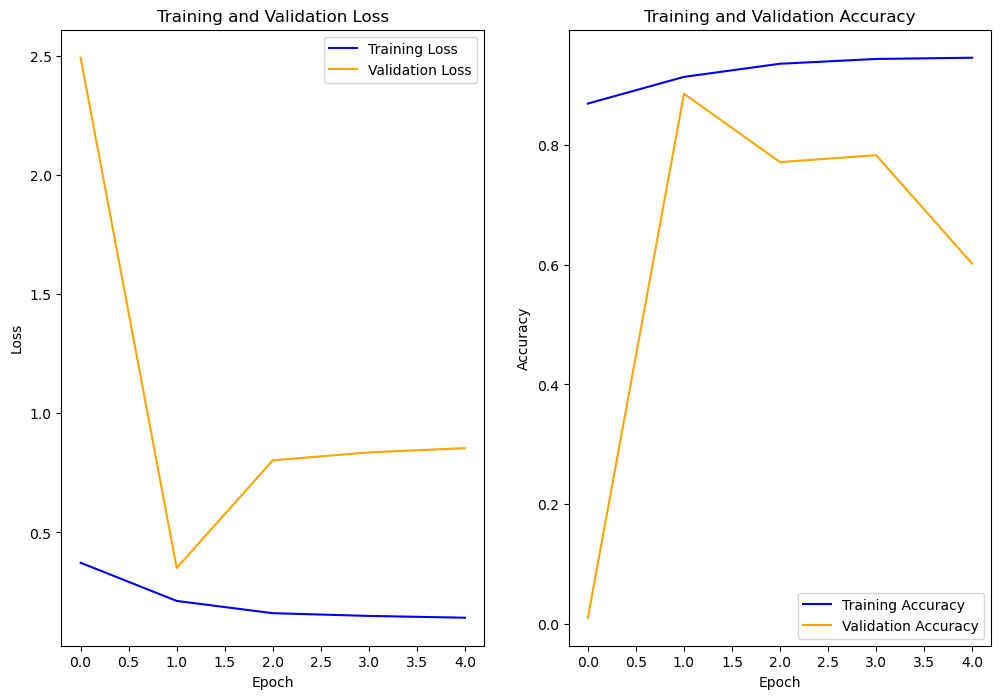

In [20]:
model_3_plots = plot_learning_curve(history_model_3)

I'll now try a model similar to model 2 with the original numebr of neurons, but with sigmoid instead of relu activation functions for the convolutional layers:

In [85]:
#model 4
model_4 = Sequential(name="model_4")
model_4.add(Rescaling((1./255), input_shape=(img_h, img_w, 3)))
model_4.add(Conv2D(16, kernel_size=3, padding='same', activation = 'sigmoid'))
model_4.add(MaxPool2D())
model_4.add(BatchNormalization())
model_4.add(Conv2D(32, kernel_size=3, padding='same', activation= 'sigmoid'))
model_4.add(MaxPool2D())
model_4.add(BatchNormalization())
model_4.add(Flatten())
model_4.add(Dense(64, activation='sigmoid'))
model_4.add(Dense(1, activation='sigmoid'))

model_4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007), loss='binary_crossentropy', metrics=['accuracy'])
model_4.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_14 (Rescaling)    (None, 64, 64, 3)         0         
                                                                 
 conv2d_27 (Conv2D)          (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                            
                                                                 
 batch_normalization_25 (Bat  (None, 32, 32, 16)       64        
 chNormalization)                                                
                                                                 
 conv2d_28 (Conv2D)          (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 16, 16, 32)       0   

In [22]:
# we'll do early stopping again
start = time()

# Fit the model
history_model_4 = model_4.fit(training, validation_data=test, epochs=20, callbacks=[early_stopping_monitor])

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/20
485/485 [==============================] - 38s 75ms/step - loss: 0.3964 - accuracy: 0.8166 - val_loss: 0.3931 - val_accuracy: 0.8076
Epoch 2/20
485/485 [==============================] - 38s 77ms/step - loss: 0.2948 - accuracy: 0.8729 - val_loss: 1.1439 - val_accuracy: 0.5436
Epoch 3/20
485/485 [==============================] - 36s 73ms/step - loss: 0.2588 - accuracy: 0.8903 - val_loss: 0.4678 - val_accuracy: 0.7902
Epoch 4/20
485/485 [==============================] - 41s 83ms/step - loss: 0.2377 - accuracy: 0.9014 - val_loss: 0.2358 - val_accuracy: 0.8928
Epoch 5/20
485/485 [==============================] - 37s 77ms/step - loss: 0.2046 - accuracy: 0.9206 - val_loss: 0.7593 - val_accuracy: 0.6291
Epoch 6/20
485/485 [==============================] - 36s 74ms/step - loss: 0.1789 - accuracy: 0.9343 - val_loss: 0.0759 - val_accuracy: 0.9795
Epoch 7/20
485/485 [==============================] - 33s 68ms/step - loss: 0.1493 - accuracy: 0.9458 - val_loss: 0.1144 - val_accuracy:

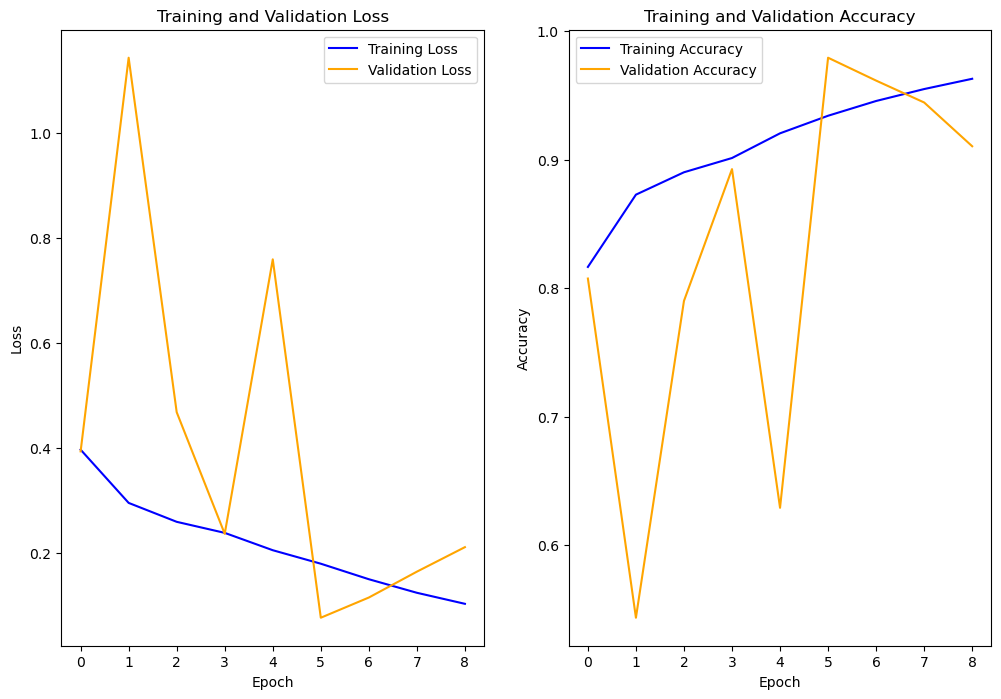

In [23]:
model_4_plots = plot_learning_curve(history_model_4)

With sigmoid activation functions in the convolutional layers, the network hits peak validation accuracy after the 5th epoch and stops early after the 8th when validation accuracy does not improve further. The val loss and accuracy are very volatile again even with a slower learning rate.

In [48]:
max(history_model_4.history['val_accuracy'])

0.9269118905067444

In [49]:
max(history_model_3.history['val_accuracy'])

0.9937076568603516

So the network with two convolutional layers and one dense layer all using the relu activation function performed better than the one with sigmoid activation functions. And the validation loss and accuracy are still very volatile even with the reduced learning rate. I could try reducing it further. And after that, I will try an additional convolutional layer, using relu activation again.

In [86]:
model_4a = Sequential(name="model_4a")
model_4a.add(Rescaling((1./255), input_shape=(img_h, img_w, 3)))
model_4a.add(Conv2D(16, kernel_size=3, padding='same', activation = 'sigmoid'))
model_4a.add(MaxPool2D())
model_4a.add(BatchNormalization())
model_4a.add(Conv2D(32, kernel_size=3, padding='same', activation= 'sigmoid'))
model_4a.add(MaxPool2D())
model_4a.add(BatchNormalization())
model_4a.add(Flatten())
model_4a.add(Dense(64, activation='sigmoid'))
model_4a.add(Dense(1, activation='sigmoid'))

model_4a.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0006), loss='binary_crossentropy', metrics=['accuracy'])

In [25]:
start = time()

# Fit the model
history_model_4a = model_4a.fit(training, validation_data=test, epochs=20, callbacks=[early_stopping_monitor])

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/20
485/485 [==============================] - 33s 65ms/step - loss: 0.3972 - accuracy: 0.8171 - val_loss: 0.7401 - val_accuracy: 0.5757
Epoch 2/20
485/485 [==============================] - 36s 74ms/step - loss: 0.2945 - accuracy: 0.8744 - val_loss: 0.2204 - val_accuracy: 0.9044
Epoch 3/20
485/485 [==============================] - 37s 75ms/step - loss: 0.2417 - accuracy: 0.9057 - val_loss: 0.3273 - val_accuracy: 0.8560
Epoch 4/20
485/485 [==============================] - 37s 76ms/step - loss: 0.2082 - accuracy: 0.9204 - val_loss: 0.1173 - val_accuracy: 0.9609
Epoch 5/20
485/485 [==============================] - 37s 77ms/step - loss: 0.1754 - accuracy: 0.9351 - val_loss: 0.2200 - val_accuracy: 0.8990
Epoch 6/20
485/485 [==============================] - 36s 73ms/step - loss: 0.1527 - accuracy: 0.9430 - val_loss: 0.3263 - val_accuracy: 0.8630
Epoch 7/20
485/485 [==============================] - 32s 67ms/step - loss: 0.1314 - accuracy: 0.9546 - val_loss: 0.2904 - val_accuracy:

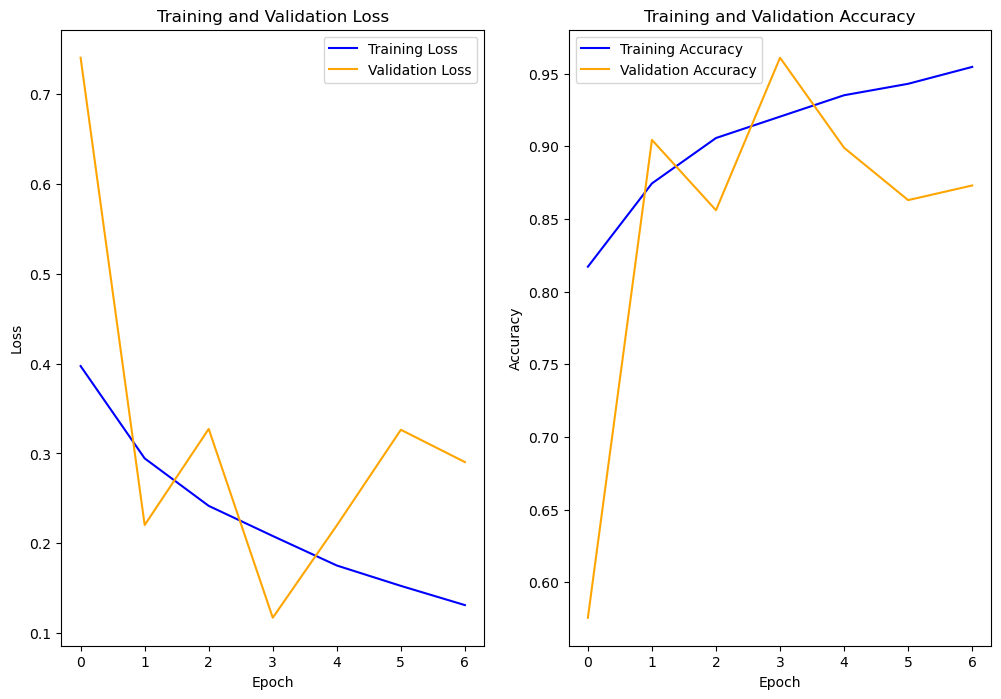

In [26]:
model_4a_plots = plot_learning_curve(history_model_4a)

In [87]:
#model 5
model_5 = Sequential(name="model_5")
model_5.add(Rescaling((1./255), input_shape=(img_h, img_w, 3)))
model_5.add(Conv2D(16, kernel_size=3, padding='same', activation = 'relu'))
model_5.add(MaxPool2D())
model_5.add(BatchNormalization())
model_5.add(Conv2D(32, kernel_size=3, padding='same', activation= 'relu'))
model_5.add(MaxPool2D())
model_5.add(BatchNormalization())
model_5.add(Conv2D(64, kernel_size=3, padding='same', activation = 'relu'))
model_5.add(Flatten())
model_5.add(Dense(64, activation='relu'))
model_5.add(Dense(1, activation='sigmoid'))

model_5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007), loss='binary_crossentropy', metrics=['accuracy'])
model_5.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_16 (Rescaling)    (None, 64, 64, 3)         0         
                                                                 
 conv2d_31 (Conv2D)          (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                            
                                                                 
 batch_normalization_29 (Bat  (None, 32, 32, 16)       64        
 chNormalization)                                                
                                                                 
 conv2d_32 (Conv2D)          (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 16, 16, 32)       0   

In [28]:
start = time()

# Fit the model
history_model_5 = model_5.fit(training, validation_data=test, epochs=20, callbacks=[early_stopping_monitor])

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/20
485/485 [==============================] - 40s 80ms/step - loss: 0.3315 - accuracy: 0.8617 - val_loss: 0.3937 - val_accuracy: 0.8537
Epoch 2/20
485/485 [==============================] - 42s 87ms/step - loss: 0.2048 - accuracy: 0.9200 - val_loss: 0.0497 - val_accuracy: 0.9841
Epoch 3/20
485/485 [==============================] - 38s 78ms/step - loss: 0.1790 - accuracy: 0.9295 - val_loss: 0.3732 - val_accuracy: 0.8575
Epoch 4/20
485/485 [==============================] - 38s 78ms/step - loss: 0.1334 - accuracy: 0.9486 - val_loss: 2.7250 - val_accuracy: 0.3957
Epoch 5/20
485/485 [==============================] - 40s 82ms/step - loss: 0.1232 - accuracy: 0.9521 - val_loss: 0.4947 - val_accuracy: 0.8548
Elapsed Time = 198.272873878479 seconds


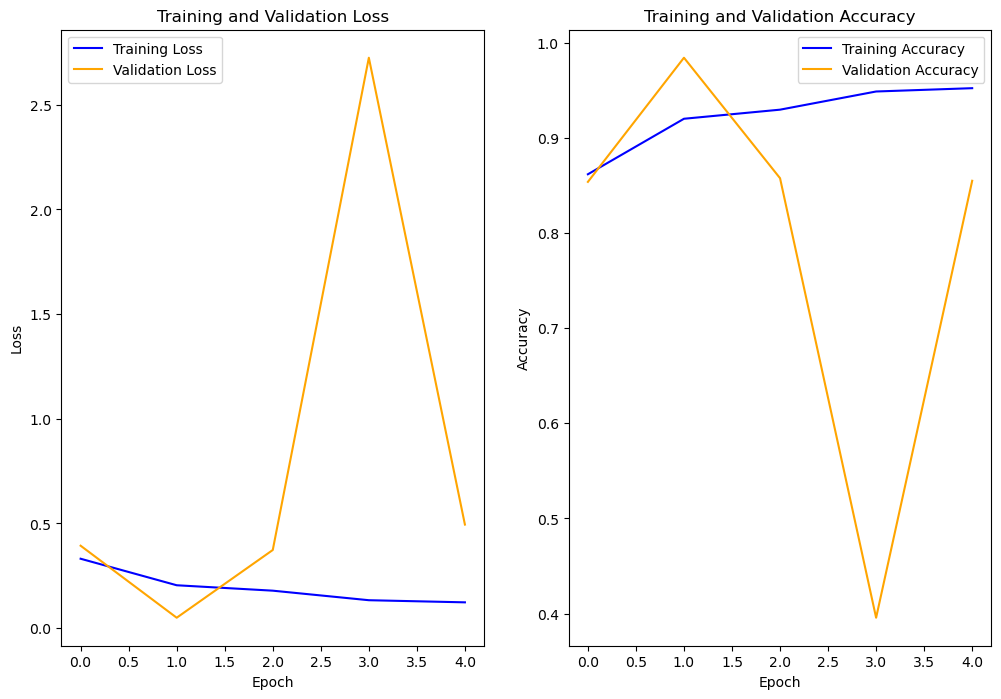

In [29]:
model_5_plots = plot_learning_curve(history_model_5)

So this same model architecture did much poorer with a larger training set. Seems quite weird... As with the smaller training set, I'll try a model similar to 5, but with SGD optimizer instead of adam:

In [88]:
#model 5a
model_5a = Sequential(name="model_5a")
model_5a.add(Rescaling((1./255), input_shape=(img_h, img_w, 3)))
model_5a.add(Conv2D(16, kernel_size=3, padding='same', activation = 'relu'))
model_5a.add(MaxPool2D())
model_5a.add(BatchNormalization())
model_5a.add(Conv2D(32, kernel_size=3, padding='same', activation= 'relu'))
model_5a.add(MaxPool2D())
model_5a.add(BatchNormalization())
model_5a.add(Conv2D(64, kernel_size=3, padding='same', activation = 'relu'))
model_5a.add(Flatten())
model_5a.add(Dense(64, activation='relu'))
model_5a.add(Dense(1, activation='sigmoid'))

model_5a.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0007), loss='binary_crossentropy', metrics=['accuracy'])


In [31]:
start = time()

# Fit the model
history_model_5a = model_5a.fit(training, validation_data=test, epochs=12)

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/12
485/485 [==============================] - 40s 80ms/step - loss: 0.3789 - accuracy: 0.8329 - val_loss: 0.6158 - val_accuracy: 0.7112
Epoch 2/12
485/485 [==============================] - 34s 70ms/step - loss: 0.2855 - accuracy: 0.8868 - val_loss: 0.3543 - val_accuracy: 0.8711
Epoch 3/12
485/485 [==============================] - 34s 71ms/step - loss: 0.2410 - accuracy: 0.9055 - val_loss: 0.4838 - val_accuracy: 0.7851
Epoch 4/12
485/485 [==============================] - 34s 69ms/step - loss: 0.2228 - accuracy: 0.9153 - val_loss: 0.2009 - val_accuracy: 0.9284
Epoch 5/12
485/485 [==============================] - 34s 70ms/step - loss: 0.2072 - accuracy: 0.9196 - val_loss: 0.2041 - val_accuracy: 0.9261
Epoch 6/12
485/485 [==============================] - 34s 70ms/step - loss: 0.1877 - accuracy: 0.9276 - val_loss: 0.2597 - val_accuracy: 0.9024
Epoch 7/12
485/485 [==============================] - 34s 70ms/step - loss: 0.1775 - accuracy: 0.9342 - val_loss: 0.1775 - val_accuracy:

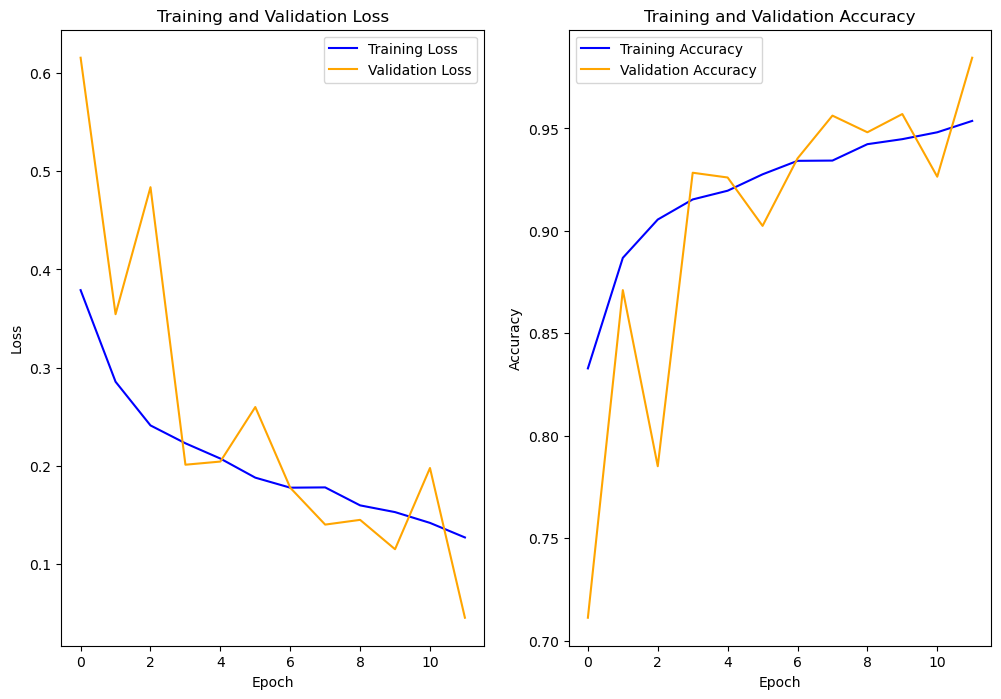

In [32]:
model_5a_plots = plot_learning_curve(history_model_5a)

I also wanted totry out an even simpler model than the first one, with only one convolutional layer:

In [89]:
model_0 = Sequential(name="model_0")
model_0.add(Rescaling((1./255), input_shape=(img_h, img_w, 3)))
model_0.add(Conv2D(16, kernel_size=3, padding='same', activation = 'relu'))
model_0.add(MaxPool2D())
model_0.add(BatchNormalization())
model_0.add(Flatten())
model_0.add(Dense(32, activation='relu'))
model_0.add(Dense(1, activation='sigmoid'))

In [34]:
model_0.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007), loss='binary_crossentropy', metrics=['accuracy'])
model_0.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                            
                                                                 
 batch_normalization_14 (Bat  (None, 32, 32, 16)       64        
 chNormalization)                                                
                                                                 
 flatten_7 (Flatten)         (None, 16384)             0         
                                                                 
 dense_14 (Dense)            (None, 32)               

In [35]:
start = time()

early_stopping_monitor = EarlyStopping(patience=3)

# Fit the model
history_model_0 = model_0.fit(training, validation_data=test, epochs=20, callbacks=[early_stopping_monitor])

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/20
485/485 [==============================] - 24s 48ms/step - loss: 0.3606 - accuracy: 0.8608 - val_loss: 0.5141 - val_accuracy: 0.7836
Epoch 2/20
485/485 [==============================] - 22s 45ms/step - loss: 0.2277 - accuracy: 0.9090 - val_loss: 3.4680 - val_accuracy: 0.0507
Epoch 3/20
485/485 [==============================] - 24s 49ms/step - loss: 0.2095 - accuracy: 0.9159 - val_loss: 0.5102 - val_accuracy: 0.8378
Epoch 4/20
485/485 [==============================] - 22s 46ms/step - loss: 0.1671 - accuracy: 0.9326 - val_loss: 0.1201 - val_accuracy: 0.9601
Epoch 5/20
485/485 [==============================] - 21s 42ms/step - loss: 0.1501 - accuracy: 0.9403 - val_loss: 0.2192 - val_accuracy: 0.9350
Epoch 6/20
485/485 [==============================] - 21s 43ms/step - loss: 0.1372 - accuracy: 0.9471 - val_loss: 3.4313 - val_accuracy: 0.0778
Epoch 7/20
485/485 [==============================] - 21s 44ms/step - loss: 0.1266 - accuracy: 0.9516 - val_loss: 5.0330 - val_accuracy:

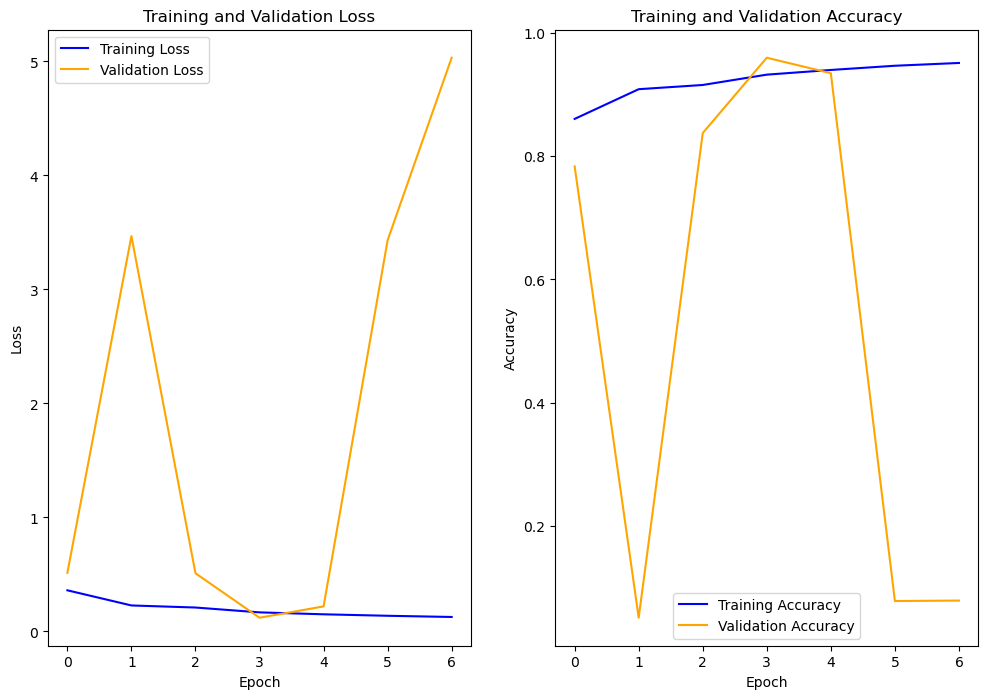

In [36]:
model_0_plots = plot_learning_curve(history_model_0)

Again, very volatile validation learning curves. I will try the same simle network with an even slower learning rate:

In [90]:
model_0a = Sequential(name="model_0a")
model_0a.add(Rescaling((1./255), input_shape=(img_h, img_w, 3)))
model_0a.add(Conv2D(16, kernel_size=3, padding='same', activation = 'relu'))
model_0a.add(MaxPool2D())
model_0a.add(BatchNormalization())
model_0a.add(Flatten())
model_0a.add(Dense(32, activation='relu'))
model_0a.add(Dense(1, activation='sigmoid'))

In [38]:
model_0a.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
model_0a.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_17 (Conv2D)          (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                            
                                                                 
 batch_normalization_15 (Bat  (None, 32, 32, 16)       64        
 chNormalization)                                                
                                                                 
 flatten_8 (Flatten)         (None, 16384)             0         
                                                                 
 dense_16 (Dense)            (None, 32)               

In [39]:
start = time()

early_stopping_monitor = EarlyStopping(patience=3)

# Fit the model
history_model_0a = model_0a.fit(training, validation_data=test, epochs=20, callbacks=[early_stopping_monitor])

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/20
485/485 [==============================] - 23s 45ms/step - loss: 0.3804 - accuracy: 0.8482 - val_loss: 0.2390 - val_accuracy: 0.8943
Epoch 2/20
485/485 [==============================] - 23s 47ms/step - loss: 0.2349 - accuracy: 0.9044 - val_loss: 0.3081 - val_accuracy: 0.9071
Epoch 3/20
485/485 [==============================] - 23s 47ms/step - loss: 0.2113 - accuracy: 0.9156 - val_loss: 0.1965 - val_accuracy: 0.9299
Epoch 4/20
485/485 [==============================] - 21s 44ms/step - loss: 0.1882 - accuracy: 0.9250 - val_loss: 0.5562 - val_accuracy: 0.7174
Epoch 5/20
485/485 [==============================] - 21s 43ms/step - loss: 0.1574 - accuracy: 0.9347 - val_loss: 0.4815 - val_accuracy: 0.8184
Epoch 6/20
485/485 [==============================] - 21s 44ms/step - loss: 0.1458 - accuracy: 0.9459 - val_loss: 0.1309 - val_accuracy: 0.9617
Epoch 7/20
485/485 [==============================] - 21s 44ms/step - loss: 0.1201 - accuracy: 0.9512 - val_loss: 1.6207 - val_accuracy:

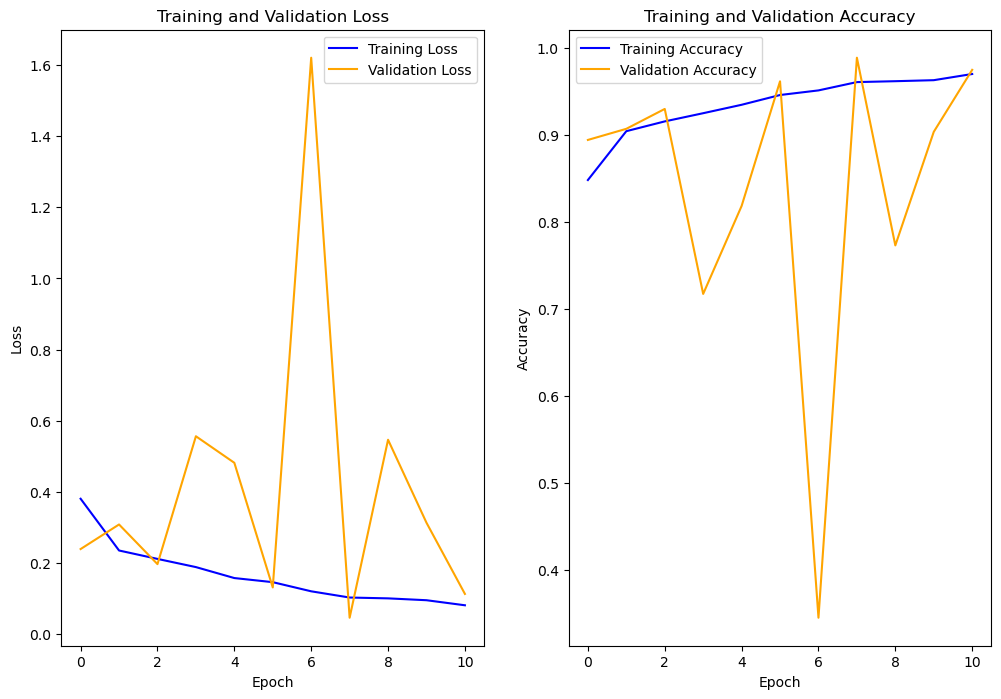

In [40]:
model_0a_plots = plot_learning_curve(history_model_0a)

Still very volatile even with a slower learning rate. Now I'll try the same but with SGD as the optimizer:

In [91]:
model_0b = Sequential(name="model_0b")
model_0b.add(Rescaling((1./255), input_shape=(img_h, img_w, 3)))
model_0b.add(Conv2D(16, kernel_size=3, padding='same', activation = 'relu'))
model_0b.add(MaxPool2D())
model_0b.add(BatchNormalization())
model_0b.add(Flatten())
model_0b.add(Dense(32, activation='relu'))
model_0b.add(Dense(1, activation='sigmoid'))

In [42]:
model_0b.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
model_0b.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_18 (Conv2D)          (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                            
                                                                 
 batch_normalization_16 (Bat  (None, 32, 32, 16)       64        
 chNormalization)                                                
                                                                 
 flatten_9 (Flatten)         (None, 16384)             0         
                                                                 
 dense_18 (Dense)            (None, 32)               

In [43]:
start = time()

early_stopping_monitor = EarlyStopping(patience=3)

# Fit the model
history_model_0b = model_0b.fit(training, validation_data=test, epochs=20, callbacks=[early_stopping_monitor])

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/20
485/485 [==============================] - 19s 38ms/step - loss: 0.4773 - accuracy: 0.7708 - val_loss: 0.5616 - val_accuracy: 0.8664
Epoch 2/20
485/485 [==============================] - 19s 39ms/step - loss: 0.4173 - accuracy: 0.8211 - val_loss: 0.4189 - val_accuracy: 0.8804
Epoch 3/20
485/485 [==============================] - 19s 38ms/step - loss: 0.3767 - accuracy: 0.8506 - val_loss: 0.3460 - val_accuracy: 0.8943
Epoch 4/20
485/485 [==============================] - 19s 38ms/step - loss: 0.3460 - accuracy: 0.8636 - val_loss: 0.3642 - val_accuracy: 0.8897
Epoch 5/20
485/485 [==============================] - 19s 39ms/step - loss: 0.3214 - accuracy: 0.8744 - val_loss: 0.2416 - val_accuracy: 0.9346
Epoch 6/20
485/485 [==============================] - 19s 39ms/step - loss: 0.3024 - accuracy: 0.8813 - val_loss: 0.3859 - val_accuracy: 0.8730
Epoch 7/20
485/485 [==============================] - 19s 40ms/step - loss: 0.2873 - accuracy: 0.8877 - val_loss: 0.3351 - val_accuracy:

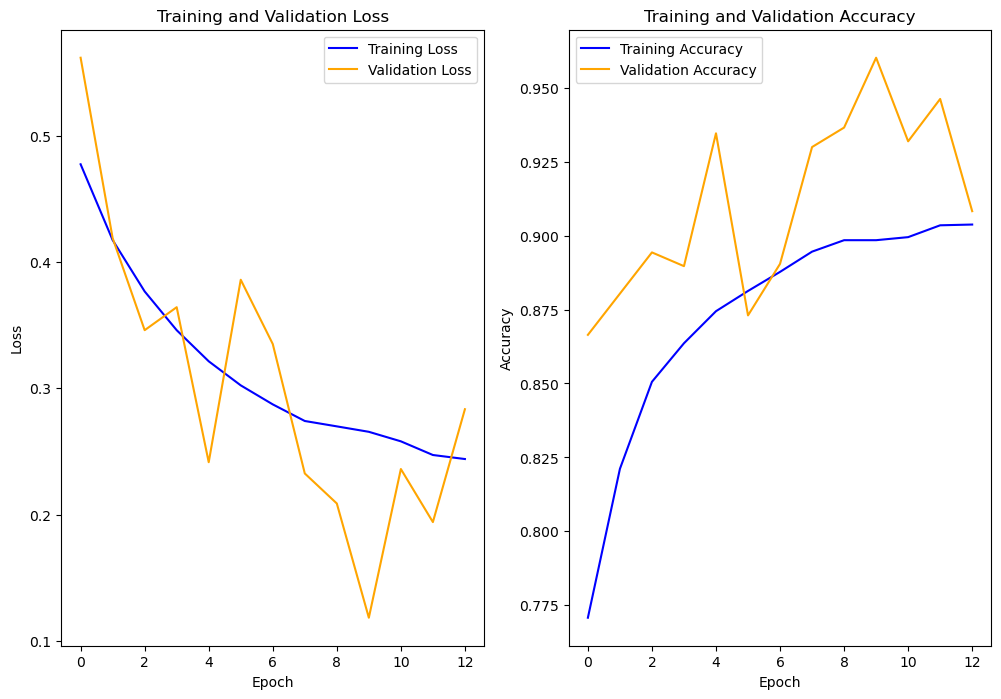

In [44]:
model_0b_plots = plot_learning_curve(history_model_0b)

So the simple model does is slightly less volatile with the SGD optimizer, but the validation accuracy is not great, and is actually higher than the training accuracy, which is not a good sign...

In [92]:
models = [model_1, model_2, model_2a, model_3, model_4, model_4a, 
             model_5, model_5a, model_0, model_0a, model_0b]
histories = [history_model_1, history_model_2, history_model_2a, history_model_3, history_model_4, history_model_4a, 
             history_model_5, history_model_5a, history_model_0, history_model_0a, history_model_0b]
print("Maximum validation accuracy achieved in for each model:")
for mod, hist in zip(models,histories):
    print(mod.name, round(max(hist.history['val_accuracy']),3))

Maximum validation accuracy achieved in for each model:
model_1 0.983
model_2 0.991
model_2a 0.969
model_3 0.885
model_4 0.979
model_4a 0.961
model_5 0.984
model_5a 0.985
model_0 0.96
model_0a 0.989
model_0b 0.96


So after reviewing these results, model 2 has the highest validation accuracy and also a smoothish learning curve. This also the best model for the smaller validation set size. Now that I have the best model selected, I will try image augmentation preprocessing to see how that affects the model:

In [95]:
image_augmentation = keras.Sequential([layers.RandomFlip("horizontal"),
                                     layers.RandomRotation(0.1),])

We can visualize the effect of the augmentation by applying image_augmentation several times to the first image in the dataset:

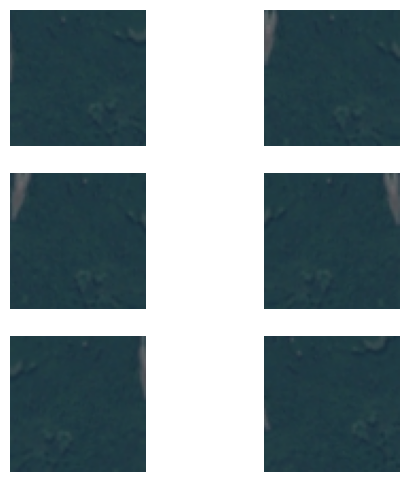

In [98]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) #to suppress to verbose warnings

plt.figure(figsize=(6,6))
for images, im in training.take(1):
    for i in range(6):
        augmented_imgs = image_augmentation(images)
        ax = plt.subplot(3,2, i+1)
        plt.imshow(augmented_imgs[0].numpy().astype("uint8"))
        plt.axis("off")

In [99]:
augmented_training_ds = training.map(lambda img, label: (image_augmentation(img), label))

In [101]:
#model 2 with augmented training set
model_2_aug = Sequential(name="model_2_with_augmented_training_set")
model_2_aug.add(Rescaling((1./255), input_shape=(img_h, img_w, 3)))
model_2_aug.add(Conv2D(16, kernel_size=3, padding='same', activation = 'relu'))
model_2_aug.add(MaxPool2D())
model_2_aug.add(BatchNormalization())
model_2_aug.add(Conv2D(32, kernel_size=3, padding='same', activation= 'relu'))
model_2_aug.add(MaxPool2D())
model_2_aug.add(BatchNormalization())
model_2_aug.add(Flatten())
model_2_aug.add(Dense(64, activation='relu'))
model_2_aug.add(Dense(1, activation='sigmoid'))

model_2_aug.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007), 
                loss='binary_crossentropy', metrics=['accuracy'])

In [102]:
start = time()

# Fit the model
history_model_2_aug = model_2_aug.fit(augmented_training_ds, validation_data=test, epochs=20, callbacks=[early_stopping_monitor])

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/20
485/485 [==============================] - 33s 65ms/step - loss: 0.3308 - accuracy: 0.8719 - val_loss: 3.5475 - val_accuracy: 0.0015
Epoch 2/20
485/485 [==============================] - 33s 68ms/step - loss: 0.2280 - accuracy: 0.9099 - val_loss: 0.6405 - val_accuracy: 0.8362
Epoch 3/20
485/485 [==============================] - 33s 69ms/step - loss: 0.1944 - accuracy: 0.9224 - val_loss: 0.4708 - val_accuracy: 0.8684
Epoch 4/20
485/485 [==============================] - 34s 70ms/step - loss: 0.1756 - accuracy: 0.9346 - val_loss: 0.2623 - val_accuracy: 0.9187
Epoch 5/20
485/485 [==============================] - 34s 71ms/step - loss: 0.1644 - accuracy: 0.9353 - val_loss: 0.3897 - val_accuracy: 0.8602
Epoch 6/20
485/485 [==============================] - 34s 71ms/step - loss: 0.1380 - accuracy: 0.9489 - val_loss: 0.2956 - val_accuracy: 0.9133
Epoch 7/20
485/485 [==============================] - 33s 69ms/step - loss: 0.1257 - accuracy: 0.9513 - val_loss: 0.3883 - val_accuracy:

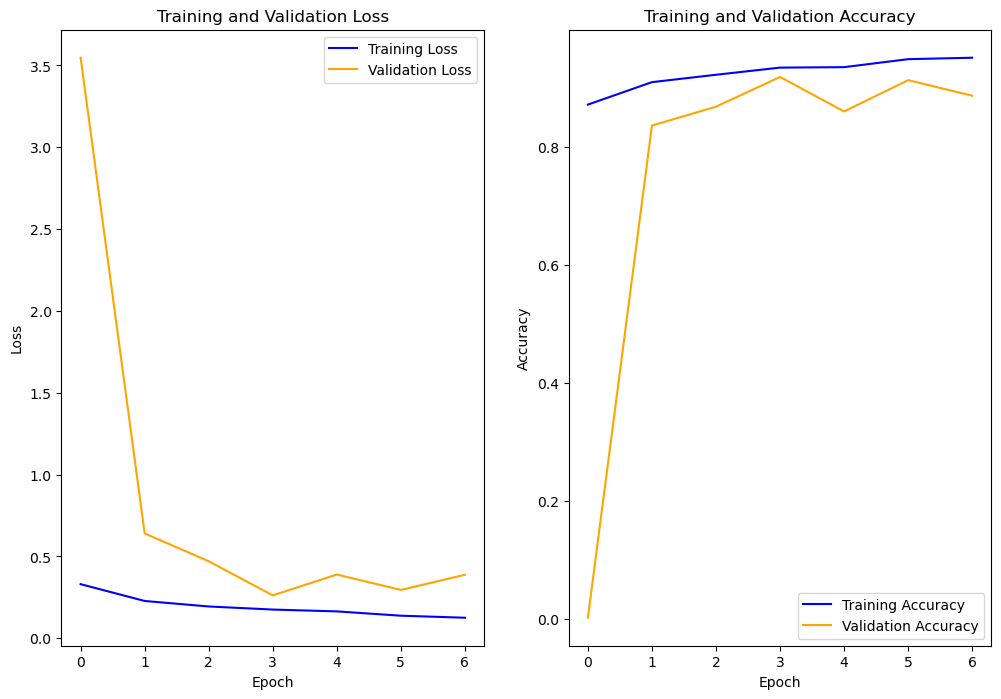

In [103]:
model_2_aug_plots = plot_learning_curve(history_model_2_aug)

The image augmentation as applied adversely affected both training and validation accuracy. Image augmentation is most useful in the case of small training set size. In this case however, with approximately 7800 training images split equally between the two classes, augmentation has decreased model performance. 